<h2 align=center>DCGANS</h2>

## Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plot_utils
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Load and Preprocess the Data

- First we can go ahead and download the dataset by using `tf.keras.datasets.fashion_mnist.load_data()`. By default, we will get data for both training and testing process, so we need to specify the tuples to hold the data: `(x_train, y_train), (x_test, y_test)`.

- Since the data value range is from 0 to 255, we have to normalize it first. We can simply convert all the data from `dtype=int` to `dtype=float32` by calling `astype()` and divide them by 255.0

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

- After that, we can go ahead and plot out a few of the images so we can see different classes of images from the dataset.

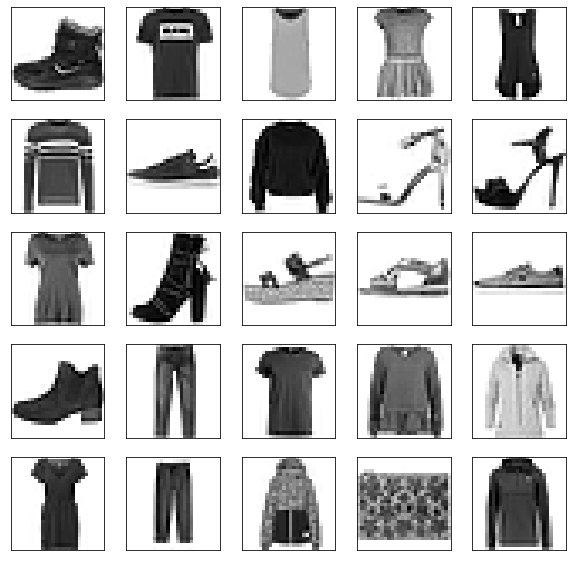

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Create Batches of Training Data

- Here, we will specify that the `batch_size` would be 32, since it is more optimal for the machine I am using, but if you're using a cloud-based machine or simply have more computational power at hand, you can set it to be a bit higher.

- We also make sure that we shuffle the dataset when loading it for training with the buffer size of 1000. We can also see parameter like `drop_remainder=True`, this is just to make sure that we are loading sufficient data while training, so if the next batch doesn't have enough images, it'd be dropped. 

- And finally, we set make sure that we prefetch the data by 1 batch for each step of training by calling `.prefect(1)`.

In [4]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
#Creates a Dataset that prefetches elements from this dataset

## Build the Generator Network for DCGAN

First we specify the number of features (`num_features`), here we choose 100, but you can increase and decrease it w.r.t your computational power.

Now we proceed to create the generator for our model. The generator will be a `Sequential` model which has the following layers:
- Dense layers of size: 7*7*256 = 12544 and the `input_shape=[num_features]`. 
- Reshape layers: just to make sure that we reshape the input. 
- Batch normalization: adjust, scale/rescale and normalize inputs _(can also be used for activations)_.
- Conv2DTranspose: a simple way to explain this is to think of it as a combination of [`UpSampling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) and [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). 
    - UpSampling2D: double each row and column from the input data. A simple version of an unpooling or opposite pooling layer is called an upsampling layer. It works by repeating the rows and columns of the input. [Source](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/#:~:text=How%20to%20Use%20the%20Conv2DTranspose,detail%20while%20it%20is%20upsampling.)
    - Conv2D: creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs. A kernel is a convolution matrix or masks which can be used for blurring, sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image. [Source](https://www.geeksforgeeks.org/keras-conv2d-class/)

In [5]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (1,1), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

We can create some random `noise` and pass it through our **pre-train** generator to see what kind of output we would get.

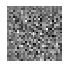

In [6]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
plot_utils.show(generated_images, 1)

## Build the Discriminator Network for DCGAN

Now we can go ahead and create our `discriminator` for the GAN. It would be a simple image classification model which consists of these layers: 
- Conv2D: as explained above
- LeakyReLU: Leaky ReLUs are one attempt to fix the “dying ReLU” problem. Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope (of 0.01, or so). That is, the function computes **f(x)=1(x<0)(αx)+1(x>=0)(x)** where α is a small constant. [Source](https://cs231n.github.io/neural-networks-1/#:~:text=Leaky%20ReLU.,%CE%B1%20is%20a%20small%20constant.)
- Dropout: this simply disable or rather drop these nodes with specified probability to further improve our model.
- Flatten: since the output of each layers differs in sizes, we need to flatten it before passing it through the final `Dense` layers for output.

In [7]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

Here we can pass our `generated_images` (from the random `noise`) through the **`discriminator`** to see if it can recognize it as a real or _generated image_. The close to zero, it means that the model is suspecting the image is generated and vice versa, the close to one, the more our discriminator is convinced that the image is real. Since it is untrained, most likely the output here would be wrong, or rather somewhat close to 0.5 since our model is not very good at this point.

In [8]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.50188303]], shape=(1, 1), dtype=float32)


## Compile the DCGAN

Here we can move on to compiling our model. Some quick explanation on `loss_function` and `optimizer`:
- `loss="binary_crossentropy`: computes the cross-entropy loss between true labels and predicted labels. [Source](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class)
- `optimizer="rmsprop"`: optimizer that implements the RMSprop algorithm. [Source](https://keras.io/api/optimizers/rmsprop/)
    - Maintain a moving (discounted) average of the square of gradients
    - Divide the gradient by the root of this average

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Specify training procedure for the DCGAN

First we generate a random seed to follow during the training.

In [10]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [11]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Here we specify our training procedure, we begin by making a function `train_dcgan` which takes the following parameter: our model, batch size, number of features, and epochs.
For each epoch:
- For each batch in the dataset:
    - Create random `noise`
    - Pass the noise through the generator to create _fake images_
    - Add the _fake images_ to the current batch from the dataset
    - Add the labels accordingly for the _fake_ and real images (0 being fake and 1 being real)
    - Enable the `discriminator` to be trainable
    - Train the `discriminator`
    - Recreate random `noise`
    - Adding labels for the newly created noise
    - Disable training for `the discriminator`
    - Train the whole `GAN` model with the `noise` and the labels.
    - Display and save images for later

In [12]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## Train the DCGAN

First we reshape the dataset for training

In [13]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

As before, we preprocess data before training.

In [14]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

We log the time and begin the training process, we would train it for 50 epochs.

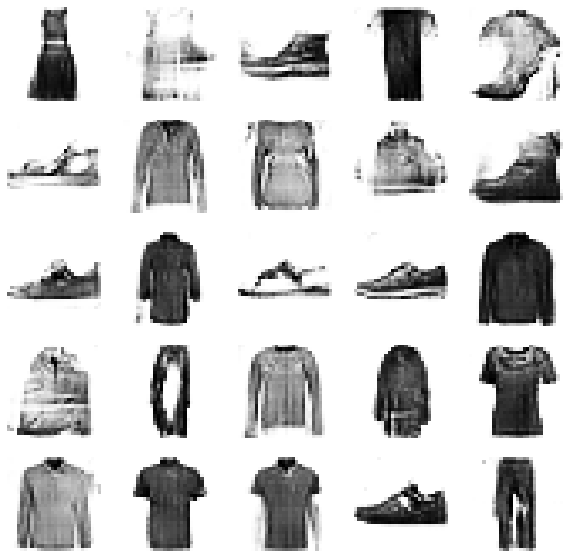

Wall time: 1h 8min 52s


In [16]:
%%time
with tf.device('/GPU:0'):
    train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

## Generate Synthetic Images with DCGAN

After training, we can start to generate images from our model. Even if we just pass random `noise` through our trained `generator`, we can recieve very convincing images.

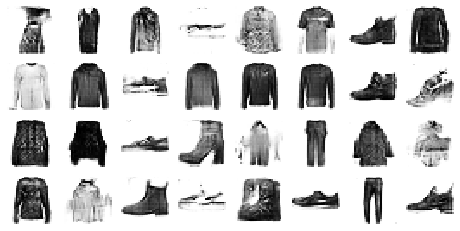

In [17]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

Finally, the most important part of this whole notebook is to create a gif and showcase our work!

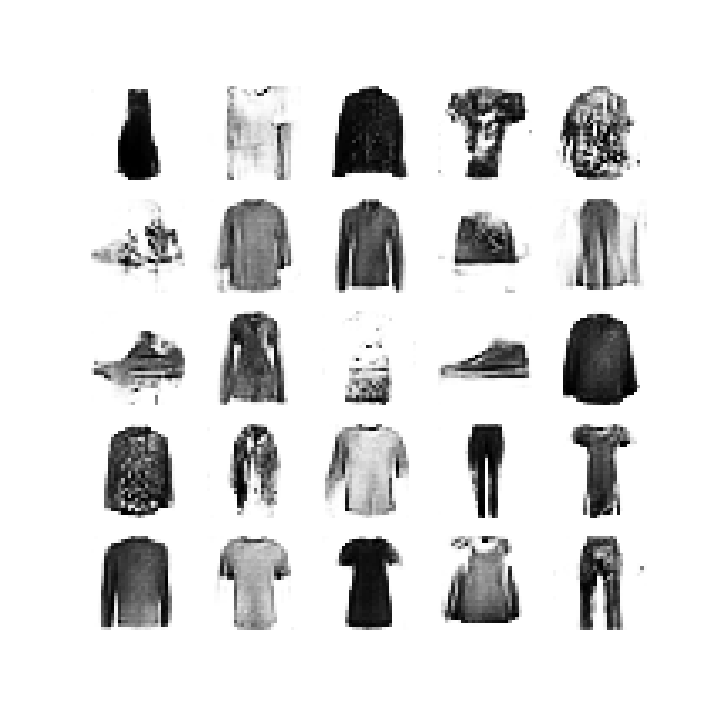

In [19]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)